In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA

mat_content = sio.loadmat('assets/face.mat')

In [2]:
# train, test data split

face_data = mat_content['X']
face_labels = mat_content['l']

x_train = []
x_test = []

y_train = []
y_test = []

n_classes = 52
images_per_class = 10

for i in range(n_classes):
    start_idx = i * images_per_class
    end_idx = start_idx + images_per_class
    
    x_train.append(face_data[:, start_idx:start_idx+8])
    x_test.append(face_data[:, start_idx+8:end_idx])

    y_train.append(face_labels[:, start_idx:start_idx+8])
    y_test.append(face_labels[:, start_idx+8:end_idx])

x_train = np.hstack(x_train)
x_test = np.hstack(x_test)
y_train = np.hstack(y_train)
y_test = np.hstack(y_test)

# Output the shapes of the training and testing sets
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (2576, 416)
Test set shape: (2576, 104)


In [3]:
x_train = x_train.astype(np.float64)
x_test = x_test.astype(np.float64)

**one-versus-the-rest**

In [4]:
# Support Vectors 시각화 
# featutre 1, 2

plt.figure(figsize=(10, 6))
for i, support_vector in enumerate(sv):
    plt.scatter(support_vector[:, 0], support_vector[:, 1], label=f'Class {i} Support Vectors')

plt.scatter(x_train[0], x_train[1], c=y_train, cmap='coolwarm', alpha=0.5, edgecolor='k')
plt.title('Support Vectors Visualization')
plt.legend()
plt.show()

NameError: name 'sv' is not defined

<Figure size 1000x600 with 0 Axes>

In [5]:
class ovrSVM:
    def __init__(self, kernel='linear', apply_pca=False):
        self.kernel = kernel
        self.apply_pca = apply_pca
        self.clfs = []
        self.sv = []
        self.y_pred = []
    
    def pca(self, x_train):
        self.overall_mean = np.average(x_train, axis=1).reshape(-1,1)
        x_train_phi = x_train - self.overall_mean

        self.PCA = PCA(n_components = x_train.shape[1]-1)
        self.PCA.fit(x_train_phi.T)
  
    def fit(self, x_train, y_train):
        y_train_binarized = label_binarize(y_train.reshape(-1), classes=np.arange(1, 53)).T

        if self.apply_pca:
            self.pca(x_train)
            x_train = self.PCA.transform((x_train-self.overall_mean).T).T
            
        for i in range(52):
            clf = SVC(kernel=self.kernel, probability=True)
            clf.fit(x_train.T, y_train_binarized[i])
            self.clfs.append(clf)
            self.sv.append(clf.support_vectors_)
    
    def predict(self, x_test):
        if self.apply_pca:
            x_test = self.PCA.transform((x_test-self.overall_mean).T).T
            
        predictions = np.zeros((x_test.shape[1], len(self.clfs)))
        for i, clf in enumerate(self.clfs):
            prob = clf.predict_proba(x_test.T)[:, 1]
            predictions[:, i] = prob
        self.y_pred = np.argmax(predictions, axis=1) + 1
        return self.y_pred          
    
    def evaluate(self, y_test):
        # recognition accuracy and confusion matrix
        accuracy = accuracy_score(y_test.reshape(-1), self.y_pred)
        print(f"Test Accuracy: {accuracy * 100:.2f}%")
        return accuracy
    
    def confusion(self, y_test):
        cm = confusion_matrix(y_test.reshape(-1), self.y_pred)
        # Confusion matrix 출력
        print("Confusion Matrix:")
        print(cm)
        # Confusion matrix 시각화
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
    
    # support vector 시각화
    def sv_visulization(self, f1=0, f2=1):
        # input f1, f2: 기준으로 보고 싶은 feature index
        plt.figure(figsize=(10, 6))
        for i, support_vector in enumerate(self.sv):
            plt.scatter(support_vector[:, f1], support_vector[:, f2], label=f'Class {i} Support Vectors')

        plt.scatter(x_train[0], x_train[1], c=y_train, cmap='coolwarm', alpha=0.5, edgecolor='k')
        plt.title('Support Vectors Visualization')
        plt.legend()
        plt.show()
        
    def success_failure(self, y_test, f1=0, f2=1):
        correct = (self.y_pred == y_test.reshape(-1))
        incorrect = (self.y_pred != y_test.reshape(-1))

        plt.figure(figsize=(10, 6))
        plt.scatter(x_test[f1, correct], x_test[f2, correct], c='green', label='Correct Predictions', alpha=0.6)
        plt.scatter(x_test[f1, incorrect], x_test[f2, incorrect], c='red', label='Incorrect Predictions', alpha=0.6)
        plt.title('Correct and Incorrect Predictions')
        plt.legend()
        plt.show()

In [14]:
ovr = ovrSVM(kernel='rbf', apply_pca=True)
ovr.fit(x_train, y_train)
ovr.predict(x_test)
ovr.evaluate(y_test)

Test Accuracy: 81.73%


0.8173076923076923

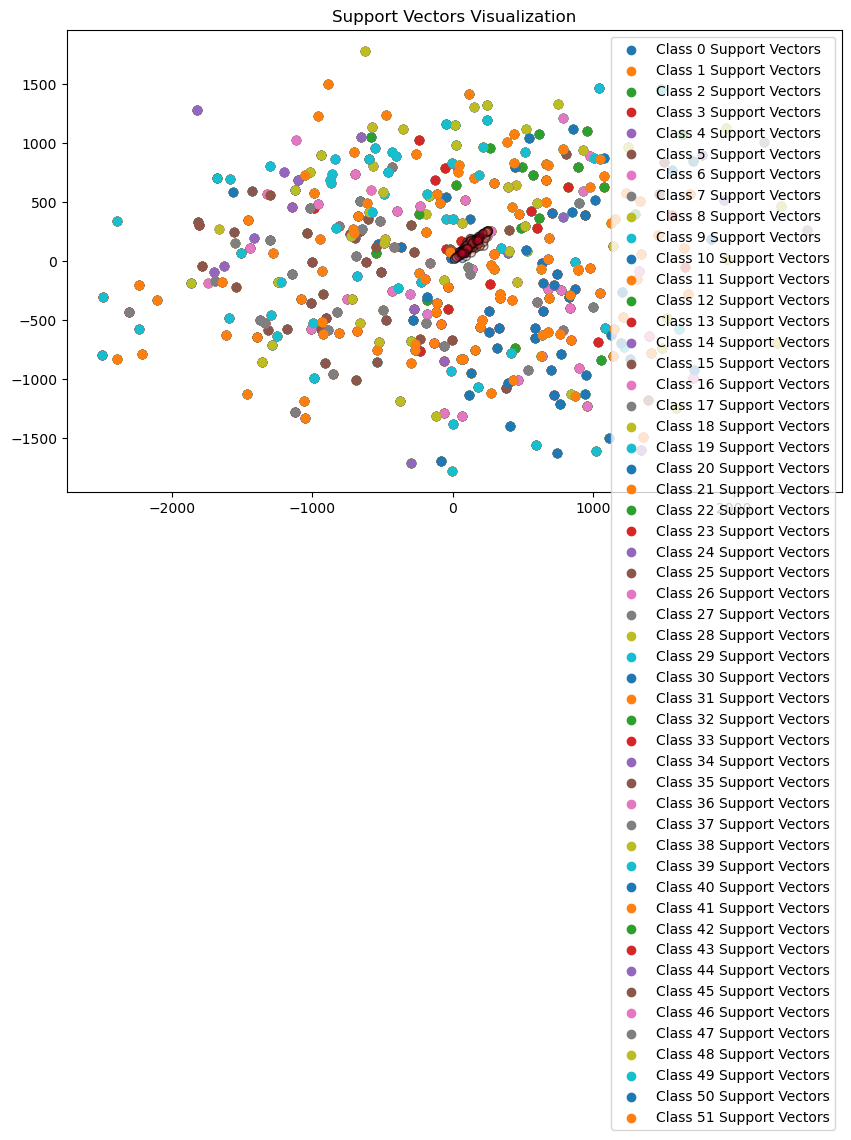

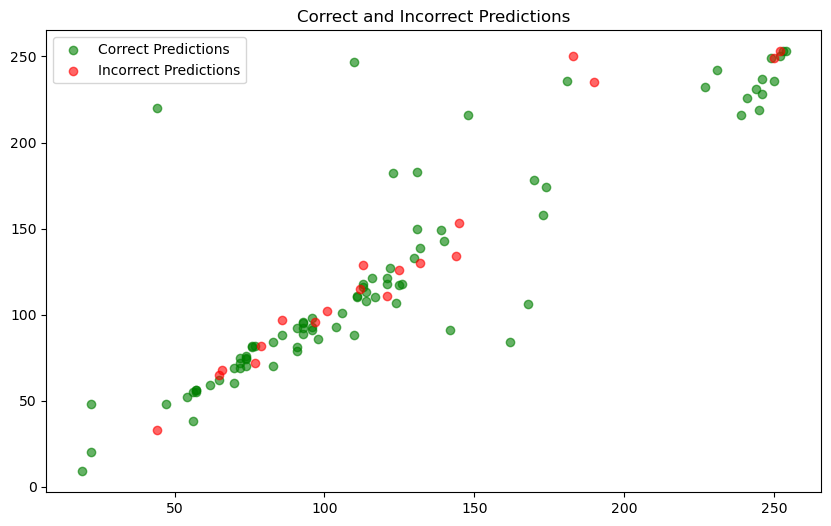

In [15]:
ovr.sv_visulization()
ovr.success_failure(y_test)

**one-versus-one**

In [4]:
class ovoSVM:
    def __init__(self, kernel='linear', apply_pca=False):
        self.kernel = kernel
        self.apply_pca = apply_pca
        self.clfs = []
        self.sv = []
    
    def pca(self, x_train):
        self.overall_mean = np.average(x_train, axis=1).reshape(-1,1)
        x_train_phi = x_train - self.overall_mean

        self.PCA = PCA(n_components = x_train.shape[1]-1)
        self.PCA.fit(x_train_phi.T)
  
    def fit(self, x_train, y_train):
        y_train = y_train.reshape(-1)
        pair_indices = list(itertools.combinations(np.unique(y_train), 2))  # 클래스 쌍의 모든 조합

        if self.apply_pca:
            self.pca(x_train)
            x_train = self.PCA.transform((x_train-self.overall_mean).T).T
        
        # 각 클래스 쌍에 대해 분류기 학습
        for (class1, class2) in pair_indices:
            # 해당 클래스들만을 추출
            idx = np.where((y_train == class1) | (y_train == class2))
            x_pair = x_train.T[idx]
            y_pair = y_train[idx]
            
            # 해당 클래스에 대해 SVM 분류기 학습
            clf = SVC(kernel=self.kernel, probability=False)  # RBF 커널 사용
            clf.fit(x_pair, y_pair)
            
            # 학습된 분류기 저장
            self.clfs.append((clf, class1, class2))
            self.sv.append(clf.support_vectors_)
    
    def predict(self, x_test):
        if self.apply_pca:
            x_test = self.PCA.transform((x_test-self.overall_mean).T).T
        
        votes = np.zeros((x_test.shape[1], len(np.unique(y_train))))  # 클래스별로 투표 집계
        
        for classifier, class1, class2 in self.clfs:
                # 각 분류기의 예측
            prediction = classifier.predict(x_test.T)
                
                # 예측에 따라 투표 집계
            for i in range(x_test.shape[1]):
                if prediction[i] == class1:
                    votes[i, class1-1] += 1
                else:
                    votes[i, class2-1] += 1

        self.y_pred = np.argmax(votes, axis=1) + 1
        return self.y_pred          
    
    def evaluate(self, y_test):
        # recognition accuracy and confusion matrix
        accuracy = accuracy_score(y_test.reshape(-1), self.y_pred)
        print(f"Test Accuracy: {accuracy * 100:.2f}%")
        return accuracy
    
    def confusion(self, y_test):
        cm = confusion_matrix(y_test.reshape(-1), self.y_pred)
        # Confusion matrix 출력
        print("Confusion Matrix:")
        print(cm)
        # Confusion matrix 시각화
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
        
    def sv_visulization(self, f1=0, f2=1):
        # input f1, f2: 기준으로 보고 싶은 feature index
        plt.figure(figsize=(10, 6))
        for i, support_vector in enumerate(self.sv):
            plt.scatter(support_vector[:, f1], support_vector[:, f2], label=f'Class {i} Support Vectors')

        plt.scatter(x_train[0], x_train[1], c=y_train, cmap='coolwarm', alpha=0.5, edgecolor='k')
        plt.title('Support Vectors Visualization')
        plt.legend()
        plt.show()
        
    def success_failure(self, y_test, f1=0, f2=1):
        correct = (self.y_pred == y_test.reshape(-1))
        incorrect = (self.y_pred != y_test.reshape(-1))

        plt.figure(figsize=(10, 6))
        plt.scatter(x_test[f1, correct], x_test[f2, correct], c='green', label='Correct Predictions', alpha=0.6)
        plt.scatter(x_test[f1, incorrect], x_test[f2, incorrect], c='red', label='Incorrect Predictions', alpha=0.6)
        plt.title('Correct and Incorrect Predictions')
        plt.legend()
        plt.show()

In [5]:
ovo = ovoSVM(kernel='rbf', apply_pca=False)
ovo.fit(x_train, y_train)
ovo.predict(x_test)
ovo.evaluate(y_test)

Test Accuracy: 66.35%


0.6634615384615384

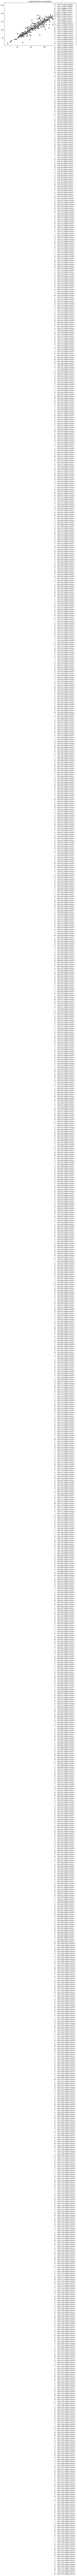

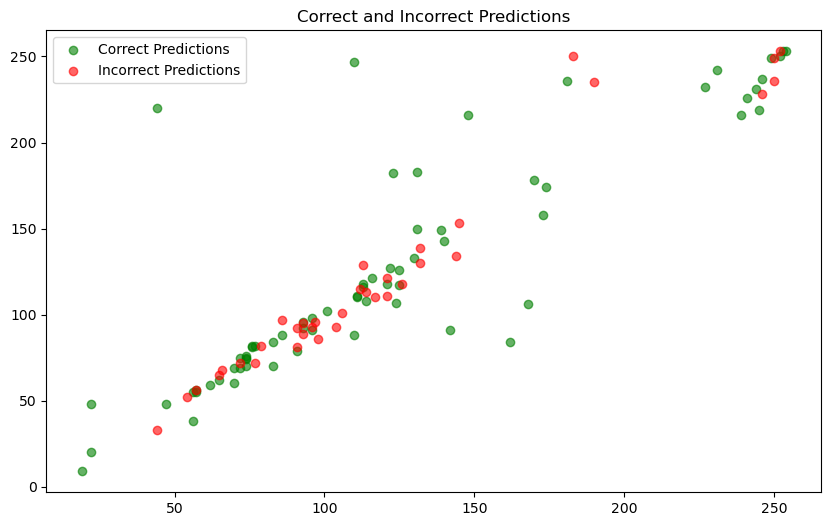

In [6]:
ovo.sv_visulization()
ovo.success_failure(y_test)